# <div style="text-align: center"> **Corso di Strutture Dati e Algoritmi** </div> 
## <div style="text-align: center"> Analisi di algoritmi di Sorting </div> 
***
## <div style="text-align: right"> Edoardo Tronconi </div> <div style="text-align: right"> n. matricola: 975734 </div>

***
## Importo librerie necessarie

In [1]:
# sistema
import os
import subprocess
import glob

#array
import numpy as np

#grafici
import matplotlib.pyplot as plt

#salvataggio e caricamento variabili
from joblib import dump, load

In [2]:
plt.rcParams.update({
    'figure.figsize' : [18,12],
    'font.size' : 16,
})

***
## Mi sposto nella cartella in cui è presente `main.x`
###### (Necessario in quanto `main.x` produce output di testo con un percorso relativo alla cartella dell'eseguibile c++, e `subprocess.run()` necessita di percorsi relativi alla cartella in cui "si trova" il notebook [[stackoverflow.com](https://stackoverflow.com/questions/39741422/python-subprocess-not-writing-output-files)] )

In [3]:
try:
    NBdir
except:
    NBdir = os.path.realpath('.')
    CPPdir = os.path.join(NBdir[:-9],'c++')

try: 
    os.chdir(CPPdir)
    if os.getcwd()[-15:] != 'ProgettoSDA/c++':
        raise Exception()

except:
    raise RuntimeError("Cartella sbagliata! Non posso eseguire ./main.x")

***
# Confronto Quicksort e altri algoritmi

In [4]:
def key_from_argsMain(algo,*argsMain): #key = (algo, size, randomized, sorted, fewUnique)
    key = [algo]
    for arg in argsMain:
        if arg.find('-size=') != -1:
            key.append(int(arg[6:]))
    if ('--randomized' in argsMain) or ('-r' in argsMain):
        key.append(True)
    else:
        key.append(False)

    if ('--sorted' in argsMain) or ('-s' in argsMain):
        key.append(True)
    else:
        key.append(False)

    if ('--fewUnique' in argsMain):
        key.append(True)
    else:
        key.append(False)
        
    return tuple(key)
    
def test_main(*argsMain):
    subprocess.run(['make','cleanRes']) #elimino i .txt precedenti così non devo cercare il file di output giusto tra molti
    subprocess.run(['./main.x', *argsMain]) #eseguo con gli argomenti passati
    
    #salvo per ogni algorimo i risultati in un dizionario
    result = {}
    for algo in ['STLsort','Insertionsort','Quicksort','Mergesort','Heapsort']:
        tempi = np.loadtxt(glob.glob('./Risultati/'+algo+'/*.txt')[0], delimiter='\n', dtype=int)
        result.update( {key_from_argsMain(algo, *argsMain) : tempi} )
    return result
    
def plot_times_main(results, *, Algos, Sizes, Random=False, Sorted=False, FewUnique=False ):
    plt.figure()
    for algo in Algos:
        Xs = []
        Ys = []
        Xmean = []
        Ymean = []
        for size in Sizes:
            y = list(filter_results(results, (algo,size,Random, Sorted, FewUnique)).values())[0]
            ymean = sum(y)/len(y)
            
            Ys.append(y)
            Ymean.append(ymean)
            
            Xs.append([size]*len(y))
            Xmean.append(size)
            
        label = 'Randomized Quicksort' if ( (algo=='Quicksort') and (Random) ) else algo
        plt.scatter(Xs,Ys, s=10, label= label)

        plt.plot(Xmean, Ymean, lw=2, alpha=0.2)
        
        plt.xlabel('Dimensione Vettore')
        plt.ylabel(r'Tempo esecuzione [ns]')
        
        rndQS = '' #' (Randomized Quicksort)' if Random else ''
        ordinato = " gia' ordinato" if Sorted else ''
        pochi = ' con pochi elementi diversi' if FewUnique else ''

        
        plt.title('Tempo di Ordinamento vettore'+ordinato+pochi+rndQS)
    leg = plt.legend()
    for handle in leg.legendHandles:
        handle.set_sizes([50])

def filter_results(results, K): #filtra i risultati con key = K ['*' = tutti]
    output = results
    for i,key in enumerate(K):
        if key != '*':
            output = dict(filter(lambda item: (item[0][i]==key), output.items()))
    return output

In [5]:
#dimensioni del vettore da provare
SIZES_MAIN = [10,50,100,250,500,750,1000,1500,2000,2500,3000,3500,4000,4500,5000]

#parametri del main da usare sempre
BASE_ARGS_MAIN = [
    '-trials=10',
    '-seed=rnd',
    '--file',
]
#parametri del main aggiuntivi da provare
ARGS_MAIN = [
     [],
     ['--randomized'],
     ['--sorted'],
     ['--fewUnique'],
     ['--randomized','--sorted'],
     ['--randomized','--fewUnique'],
     ['--sorted', '--fewUnique'],
     ['--randomized','--sorted','--fewUnique'],
]

In [9]:
resultsMain = {}
subprocess.run('make') #se fosse necessario costruisco l'eseguibile
for size in SIZES_MAIN:
    for argsMain in ARGS_MAIN:
        ARGS = [*BASE_ARGS_MAIN, *argsMain, '-size='+str(size)]
        resultsMain.update(test_main(*ARGS))

#### Caricamento rapido risultati

In [6]:
resultsMain = load(NBdir+'/resultsMain.zip')

***
## Grafici

In [7]:
ALGORITMI_MAIN = ['Insertionsort','Quicksort', 'Mergesort', 'Heapsort','STLsort']

#### Tempi su vettori casuali

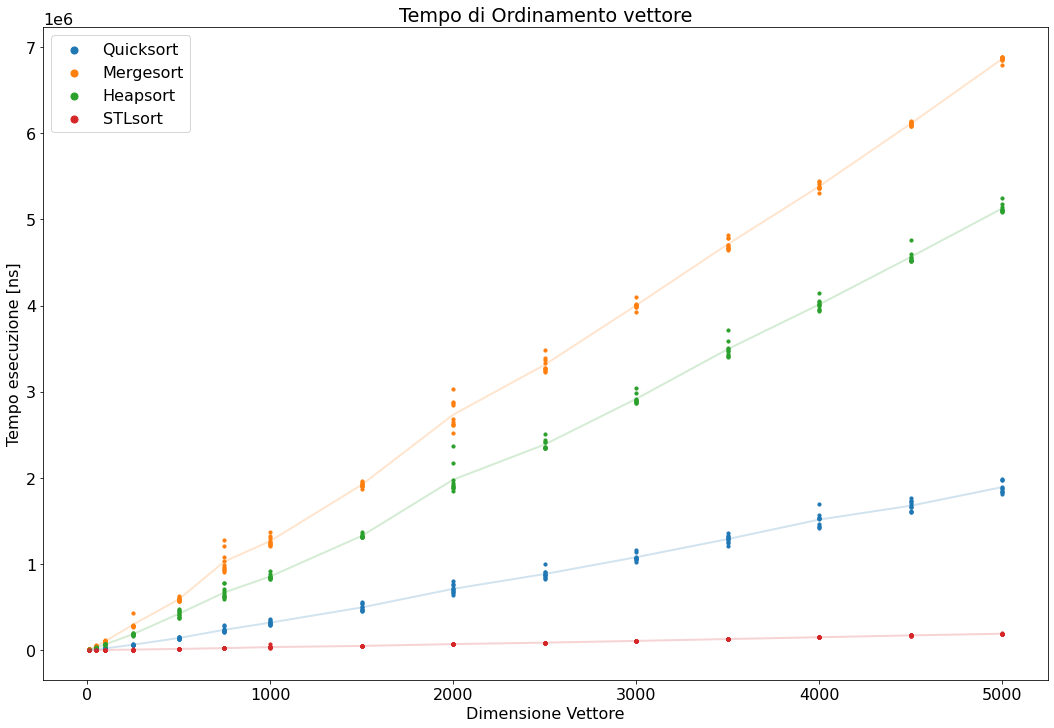

In [20]:
plot_times_main(resultsMain,
                Algos=['Quicksort', 'Mergesort', 'Heapsort', 'STLsort'],
                Sizes=SIZES_MAIN)

#### Tempi su vettori già ordinati

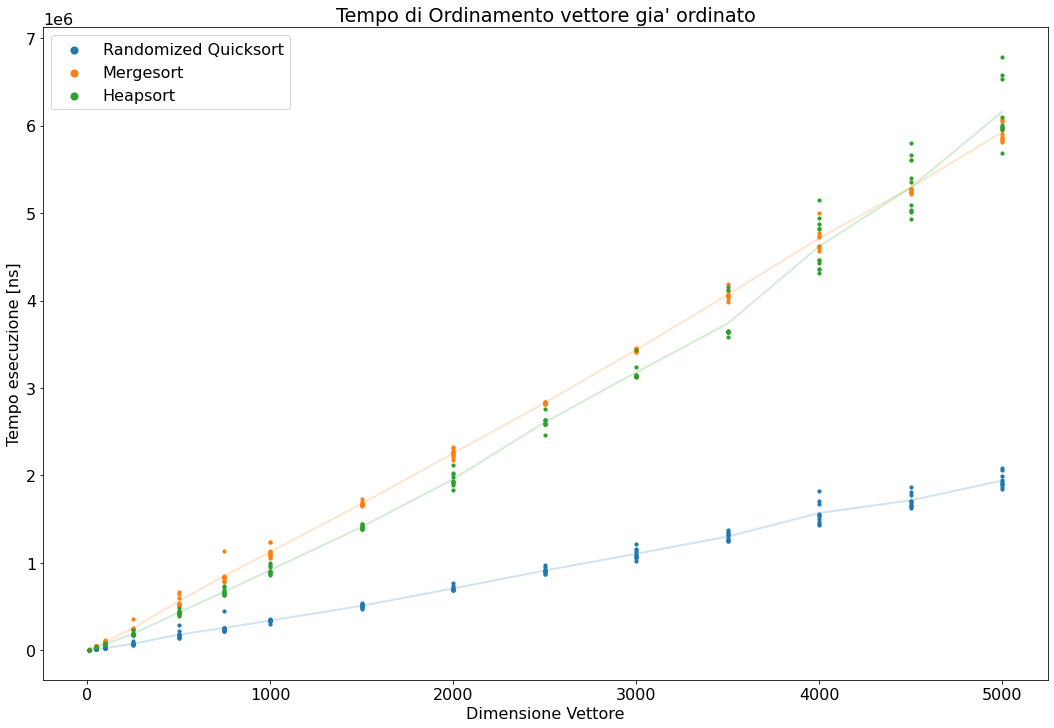

In [21]:
plot_times_main(resultsMain,
                Algos=['Quicksort', 'Mergesort', 'Heapsort'],
                Sizes=SIZES_MAIN,
                Sorted=True,
                Random=True)

#### Tempi su vettori con pochi elementi diversi

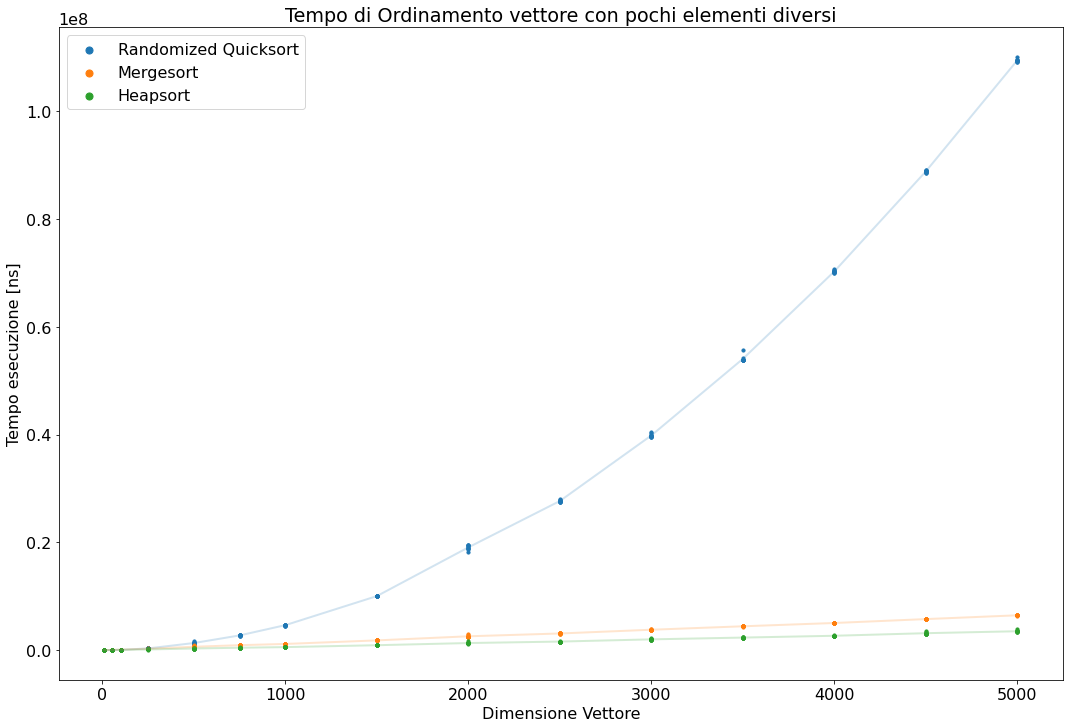

In [22]:
plot_times_main(resultsMain,
                Algos=['Quicksort','Mergesort','Heapsort'],
                Sizes=SIZES_MAIN,
                FewUnique=True,
                Random=True)

***
# Confronto tra diversi Quicksort

In [11]:
def key_from_argsQS(algo,*argsQS): #key = (algo, size, sorted, reversed, fewUnique)
    key = [algo]
    for arg in argsQS:
        if arg.find('-size=') != -1:
            key.append(int(arg[6:]))
    if ('--sorted' in argsQS):
        key.append(True)
    else:
        key.append(False)
        
    if ('--reversed' in argsQS):
        key.append(True)
    else:
        key.append(False)
        
    if ('--fewUnique' in argsQS):
        key.append(True)
    else:
        key.append(False)

    return tuple(key)

def test_QS(*argsQS):
    subprocess.run(['make','cleanRes']) #elimino i .txt precedenti così non devo cercare il file di output giusto tra molti
    subprocess.run(['./main_quicksort.x', *argsQS]) #eseguo con gli argomenti passati
    
    #salvo per ogni algorimo i risultati in un dizionario
    result = {}
    for algo in ['standardQS','randomizedQS','medianQS','randomizedMedianQS','threeWayQS','randomizedThreeWayQS','randomizedMedianThreeWayQS']:
        tempi = np.loadtxt('./Risultati/Quicksort/tempiOrdinamento_'+algo+'.txt', delimiter='\n', dtype=int)
        result.update( {key_from_argsQS(algo, *argsQS) : tempi} )
    return result

def plot_times_QS(results, *,Algos, Sizes, Sorted=False, Reversed=False, FewUnique=False ):
    plt.figure()
    for algo in Algos:
        Xs = []
        Ys = []
        Xmean = []
        Ymean = []
        for size in Sizes:
            y = list(filter_results(results, (algo,size,Sorted, Reversed, FewUnique)).values())[0]
            ymean = sum(y)/len(y)
            
            Ys.append(y)
            Ymean.append(ymean)
            
            Xs.append([size]*len(y))
            Xmean.append(size)
            
        plt.scatter(Xs,Ys, s=10, label=algo)

        plt.plot(Xmean, Ymean, lw=2, alpha=0.2)
        
        plt.xlabel('Dimensione Vettore')
        plt.ylabel('Tempo esecuzione [ns]')
        
        ordinato = " gia' ordinato" if Sorted else ''
        contrario = " ordinato in verso decrescente" if Reversed else ''
        pochi = " con pochi elementi diversi" if FewUnique else ''

        
        plt.title('Tempo di Ordinamento vettore'+ordinato+contrario+pochi)
    leg = plt.legend()
    for handle in leg.legendHandles:
        handle.set_sizes([50])

In [12]:
#dimensioni del vettore da provare
SIZES_QS = [10,50,100,250,500,750,1000,1500,2000,2500,3000,3500,4000,4500,5000]


#parametri di mainQS da usare sempre
BASE_ARGS_QS = [
    '-trials=10',
    '-seed=rnd',
    '--file',
]

#parametri di mainQS aggiuntivi da provare
ARGS_QS = [
     [],
     ['--sorted'],
     ['--reversed'],
     ['--fewUnique'],
     ['--sorted','--fewUnique'],
     ['--reversed','--fewUnique'],
]

In [ ]:
resultsQS = {}
subprocess.run(['make', 'qs']) #se fosse necessario costruisco l'eseguibile
for size in SIZES_QS:
    for argsQS in ARGS_QS:
        ARGS = [*BASE_ARGS_QS, *argsQS, '-size='+str(size)]
        resultsQS.update(test_QS(*ARGS))

#### Caricamento rapido risultati

In [13]:
resultsQS = load(NBdir+'/resultsQS.zip')

***
## Grafici

In [14]:
ALGORITMI_QS = ['standardQS','randomizedQS','medianQS','randomizedMedianQS','threeWayQS','randomizedThreeWayQS','randomizedMedianThreeWayQS']

#### Tempi su vettori casuali

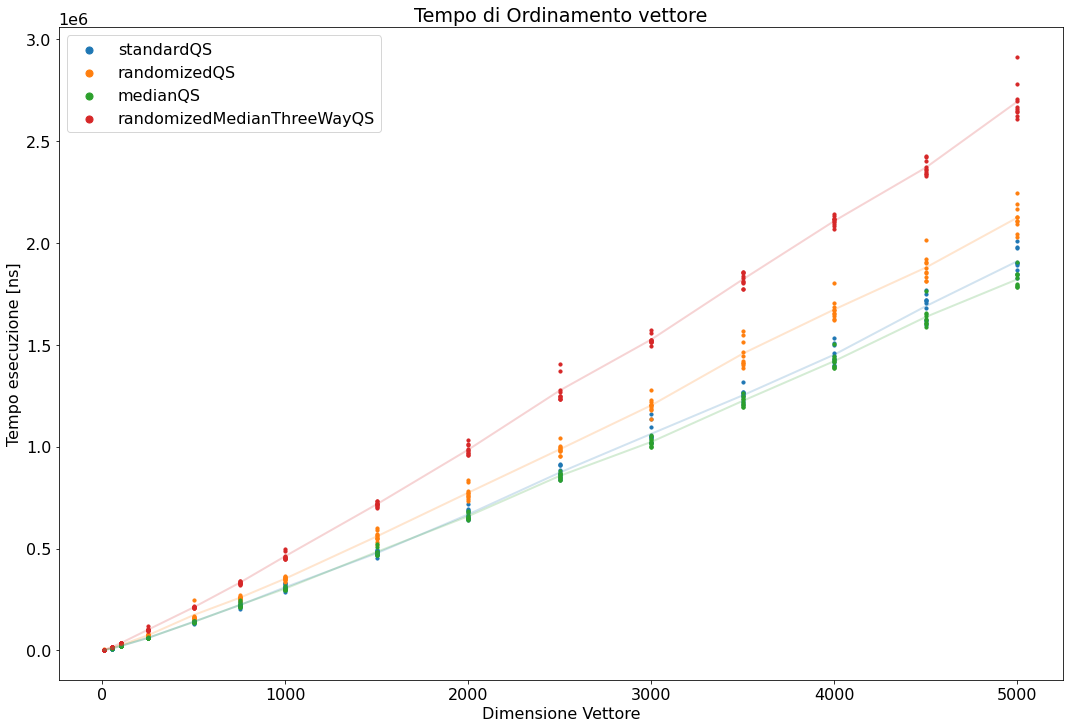

In [15]:
plot_times_QS(resultsQS,
              Algos=['standardQS','randomizedQS','medianQS','randomizedMedianThreeWayQS'], 
              Sizes=SIZES_QS)

#### Tempi su vettori già ordinati

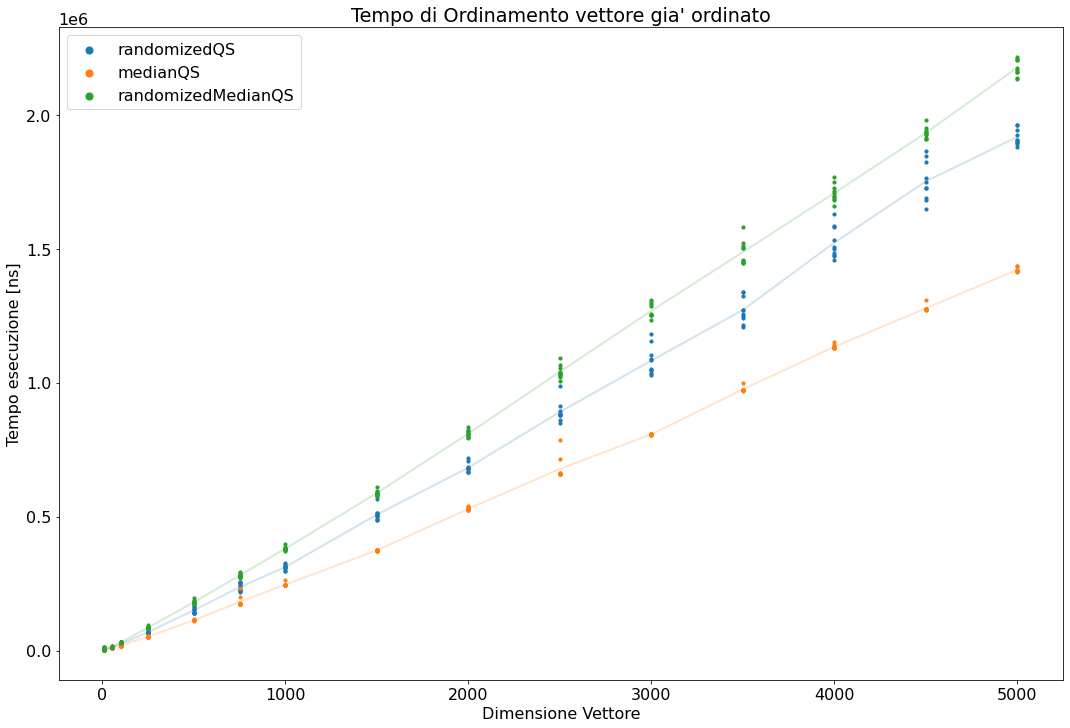

In [23]:
plot_times_QS(resultsQS,
              #Algos=['standardQS','randomizedQS', 'medianQS'],
              Algos=['randomizedQS','medianQS','randomizedMedianQS'],
              Sizes=SIZES_QS, 
              Sorted=True)

#### Tempi su vettori con pochi elementi diversi

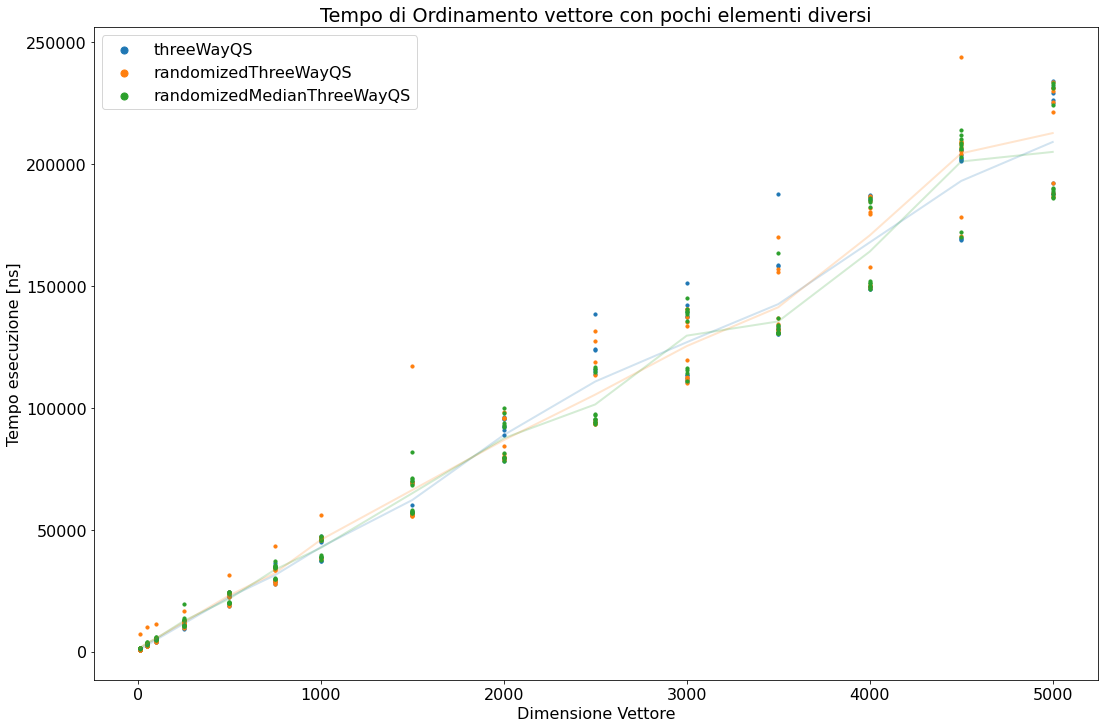

In [24]:
plot_times_QS(resultsQS, 
              #Algos=['standardQS','randomizedQS', 'medianQS','threeWayQS'],
              Algos=['threeWayQS', 'randomizedThreeWayQS', 'randomizedMedianThreeWayQS'],
              Sizes=SIZES_QS,
              FewUnique=True,
              Sorted=False)

***